import libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob

test gpu, mount drive and root path

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

from google.colab import drive

drive.mount('/content/gdrive')


root_path ="/content/gdrive/MyDrive/Colab Notebooks/kaggle/Data"
%cd $root_path
%pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/kaggle/Data


'/content/gdrive/MyDrive/Colab Notebooks/kaggle/Data'

The functions that applies edge detection

In [ ]:
from scipy.signal import convolve2d

kernel_x = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])
kernel_y = np.array([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]])
def edges(img):
    output1 = convolve2d(img, kernel_x)
    output2 = convolve2d(img, kernel_y)
    new=np.sqrt(np.square(output1)+np.square(output2))
    return new

def preProcess(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img = img/255.0
    a = edges(img)
    a = a[:128,:128]
    img1 = cv2.resize(img,(128,128))
    img1 = np.expand_dims(img1,axis=-1)
    img2 = cv2.resize(a,(128,128))
    img2 = np.expand_dims(img2,axis=-1)

    return np.concatenate((img1,img2), axis=2)

In [ ]:
def preProcess1(img):
  img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  img = img/255.0
  a = edges(img)
  return img

The function that loads the datasets

In [ ]:
def load_datasets(img_dir):
  img_dir_ = img_dir
  data_path = os.path.join(img_dir_,'*.jpg')
  split=img_dir.split("/")[7:9]
  files = glob.glob(data_path)
  train = []
  images=[]
  for f1 in files:
    img = cv2.imread(f1)
    img = preProcess(img)
    train.append(img)
  return train

Apply load_dataset function for powerline and non-powerline training datasets

In [ ]:
train_non_powerline = load_datasets("/content/gdrive/MyDrive/Colab Notebooks/kaggle/Data/train/Nopowerline_2")
train_powerline = load_datasets("/content/gdrive/MyDrive/Colab Notebooks/kaggle/Data/train/Powerline_2")

Creating the label datas

In [ ]:
powerline_label = np.ones(len(train_powerline))
non_powerline_label = np.zeros(len(train_non_powerline))

In [ ]:
print(len(non_powerline_label))

1455


Concatenate two datasets and their label sets

In [ ]:
train = train_powerline + train_non_powerline
train_label = np.concatenate((non_powerline_label,powerline_label))

In [ ]:
print(len(train))

2228


Zipping the images and labels then shuffling them

In [ ]:
import random
temp = list(zip(train,train_label))
for i in range(1000):
    random.shuffle(temp)
train,train_label=zip(*temp)
train = np.array(train)
train_label = np.array(train_label)

Control the shape and the size of the shuffled training dataset

In [ ]:
print("data_shape",train[0].shape)
train = np.array(train)
train_labels = np.array(train_label)
print("train_data_size",train.shape)

NameError: ignored

Importing the neccecary libraries to create the model

In [ ]:
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import load_model
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Creating the model with layer functions

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (128,128,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))




model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

View the model's summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      1632      
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        51264     
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        102464    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

Optimization operations on the model and initializing the epoch and batch_size parameters

In [ ]:
optimizer =  RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer =optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
epochs = 50
batch_size = 100
# rescaling the pixel values
X_train, X_val, Y_train, Y_val = train_test_split(train, train_labels, test_size = 0.2, random_state= 2)
X_train=X_train/255.0
X_val=X_val/255.0

Using the 'EarlyStopping' function to optimize the training process

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

Training process

In [ ]:
history = model.fit(X_train,Y_train, batch_size=batch_size, epochs = epochs,verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,validation_data=(X_val,Y_val))

Epoch 1/50
17/17 [==============================] - 4s 223ms/step - loss: 1.0138 - accuracy: 0.6429 - val_loss: 0.6435 - val_accuracy: 0.6928
Epoch 2/50
17/17 [==============================] - 4s 222ms/step - loss: 0.6519 - accuracy: 0.6463 - val_loss: 0.6269 - val_accuracy: 0.6928
Epoch 3/50
17/17 [==============================] - 4s 209ms/step - loss: 0.6576 - accuracy: 0.6421 - val_loss: 0.6172 - val_accuracy: 0.6928
Epoch 4/50
17/17 [==============================] - 4s 209ms/step - loss: 0.6576 - accuracy: 0.6373 - val_loss: 0.6201 - val_accuracy: 0.6928
Epoch 5/50
17/17 [==============================] - 4s 214ms/step - loss: 0.6529 - accuracy: 0.6457 - val_loss: 0.6274 - val_accuracy: 0.6928
Epoch 6/50
17/17 [==============================] - 4s 213ms/step - loss: 0.6481 - accuracy: 0.6498 - val_loss: 0.6261 - val_accuracy: 0.6928
Epoch 7/50
17/17 [==============================] - 4s 207ms/step - loss: 0.6562 - accuracy: 0.6403 - val_loss: 0.6169 - val_accuracy: 0.6928
Epoch 

Viewing accuracy and loss values via different graphs

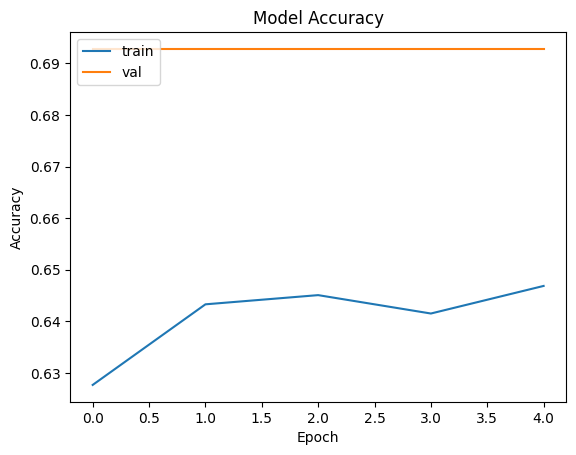

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

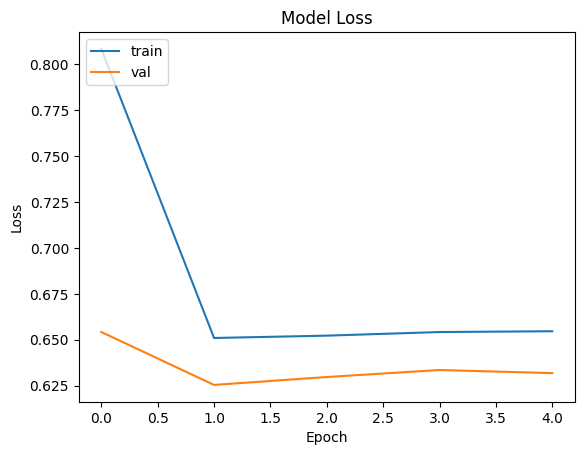

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

# Title
fig.update_layout(
    title_text="Loss/Accuracy of powerline model"
)

# x-axis title
fig.update_xaxes(title_text="Epoch")

# y-axis titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

Loading the test images

In [ ]:
img_dir = "/content/gdrive/MyDrive/Colab Notebooks/kaggle/Data/test"

test_images,test_labels=load_datasets(img_dir)
test_images=np.array(test_images)

test_images=test_images/255.0
test_images.shape

Prediction process through model on the test dataset

In [ ]:
test_labels=model.predict(test_images)

Labeling the test images using threshold value

In [ ]:
img_dir = "/content/gdrive/MyDrive/Colab Notebooks/kaggle/Data/test"
data_path = os.path.join(img_dir,'*.bmp')
files = glob.glob(data_path)
labels=[]
for i in test_labels:
    if(i>0.5):
        labels.append("YES")
    else:
        labels.append("NO")
test_names=[]
for f1 in files:
    test_names.append(f1)
for i in range(0,len(test_images)):
    test_names[i]=test_names[i][39:]
test_names[0]

Viewing the test results

In [ ]:
file=pd.DataFrame(test_names,columns=['image file name'])
file['Powerline']=labels
file

Saving the model

In [ ]:
model.save("/content/gdrive/MyDrive/Colab Notebooks/kaggle/recognizance-2/model14.h5")

Visualizing the Model

In [ ]:
! pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 12.6 MB/s eta 0:00:00


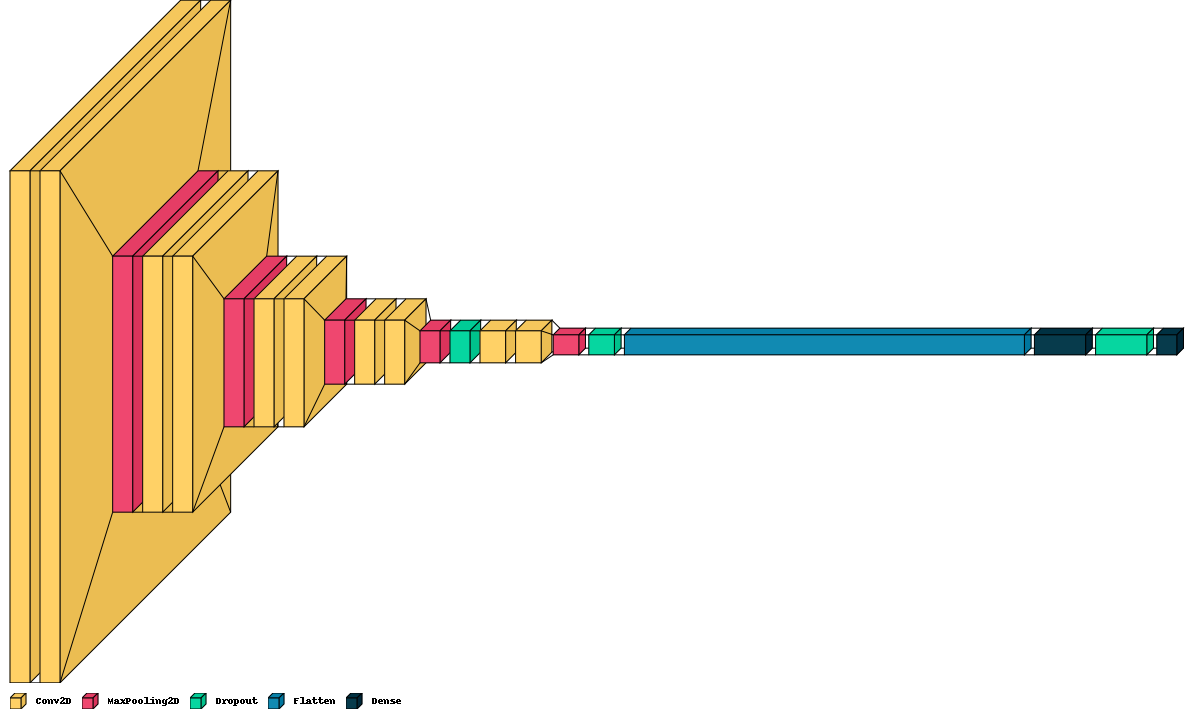

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

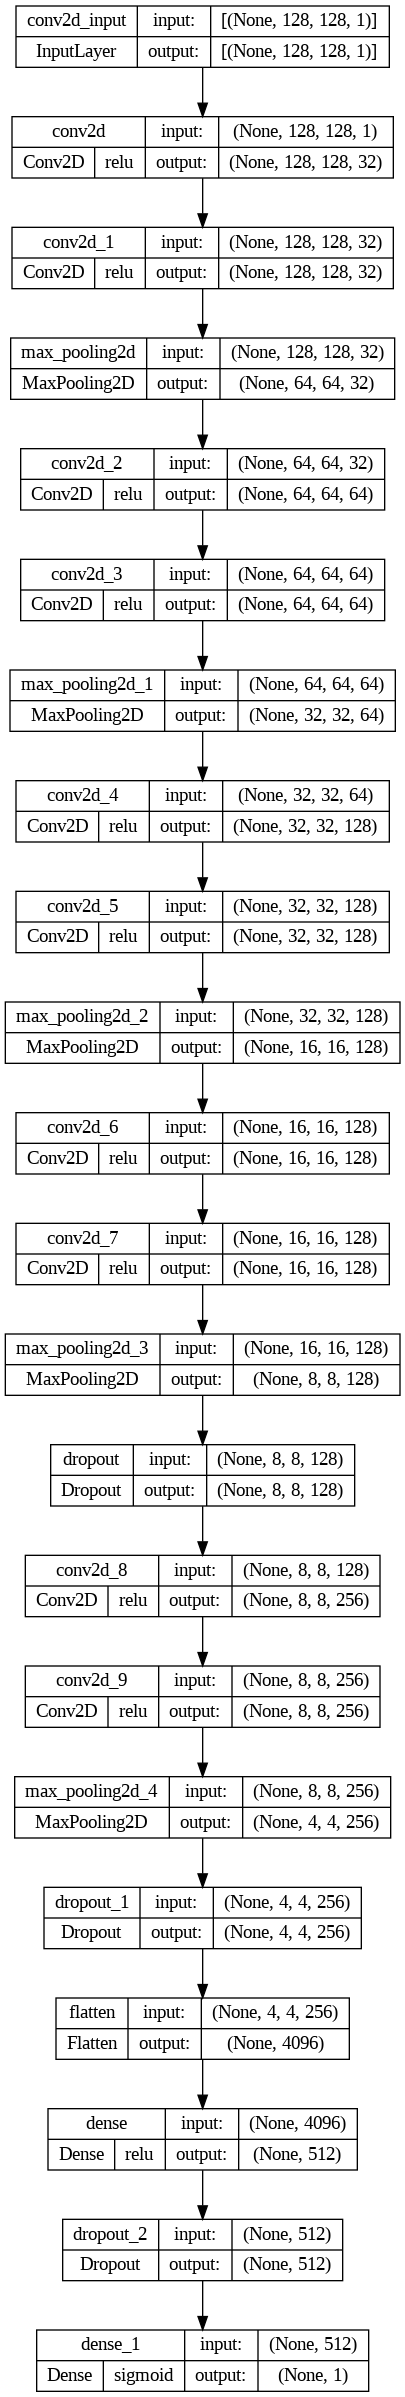

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)